In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.tokenize import TweetTokenizer
from nltk import FreqDist
import pandas as pd
import numpy as np
import random
import os
import time
import shutil
import random
from typing import Tuple
from argparse import Namespace
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import math
from itertools import permutations

# Modelo de Lenguaje y Evaluación

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Preprocesar todos los tweets




Para preprocesar todos los tweets se utilizó una clase para el modelo como se vió en clase. Donde se tenía un set de palabras que son las remove words. Se agregó al vocabulario 5000 términos y además de los caracteres especiales de inicio y fin de secuencia. Además del token de caracter desconocido

In [ ]:
from nltk import probability
class NgramData():
    def __init__(self, vocab_max: int=5000, tokenizer=None, embeddings_model=None):
            self.tokenizer = tokenizer if tokenizer else self.default_tokenizer
            self.punct = set(['.',',',';',':','-','^','»','!','¡','¿','?','""','\'','...','<url>','*','@usuario'])
            self.vocab_max = vocab_max
            self.UNK = "<unk>"
            self.SOS = '<s>'
            self.EOS = '</s>'
            self.embeddings_model = embeddings_model
            self.model_unigram = None
            self.model_bigram_freq = None
            self.model_trigram= None
            self.model_unigram_freq = None
            self.model_bigram_freq = None
            self.model_trigram_freq = None
    
    def get_vocab_size(self) -> int:
        return len(self.vocab)
            
    def default_tokenizer(self, doc: str) -> list:
        return doc.splot(" ")
    
    def remove_word(self, word: str) -> bool:
        word = word.lower()
        is_punct = True if word in self.punct else False
        is_digit = word.isnumeric()
        return is_punct or is_digit
    
    def get_vocab(self, corpus: list) -> set:
        self.freq_dist = FreqDist([w.lower() for sentence in corpus\
                                         for w in self.tokenizer(sentence)\
                                         if not self.remove_word(w)])
    
        sorted_words = self.sortFreqDict(self.freq_dist)[:self.vocab_max-3]
        return set(sorted_words)
    
    def sortFreqDict(self, freq_dist) -> list:
        freq_dict = dict(freq_dist)
        return sorted(freq_dict, key=freq_dict.get, reverse=True)
    
    def fit(self, corpus: list) -> None:
        self.vocab = self.get_vocab(corpus)
        self.vocab.add(self.UNK)
        self.vocab.add(self.SOS)
        self.vocab.add(self.EOS)
        self.w2id = {}
        self.id2w = {}
        
        id = 0
        for doc in corpus:
            for word in self.tokenizer(doc):
                word_ = word.lower()
                if word_ in self.vocab and not word_ in self.w2id:
                    self.w2id[word_] = id
                    self.id2w[id] = word_            
                    id+= 1
        
        self.w2id.update(
            {
                self.UNK: id,
                self.SOS: id+1,
                self.EOS: id+2
            }
        )
        
        self.id2w.update(
            {
                id: self.UNK,
                id+1: self.SOS,
                id+2: self.EOS
            }
        )
    
    def transform(self, corpus: list, N: int) -> Tuple[np.ndarray, np.ndarray]:
        X_ngrams = []
        y = []
        
        for doc in corpus:
            doc_ngram = self.get_ngram_doc(doc, N)
            for words_window in doc_ngram:
                words_window_ids = [self.w2id[w] for w in words_window]
                X_ngrams.append(list(words_window_ids[:-1]))
                y.append(words_window_ids[-1])
            words_window = list(doc_ngram[len(doc_ngram)-1][1:])
            words_window_ids = [self.w2id[w] for w in words_window] 
            
            X_ngrams.append(list(words_window_ids))
        return np.array(X_ngrams), np.array(y)
    
    def get_ngram_doc(self, doc: set,N: int) -> list:
        doc_tokens = self.tokenizer(doc)
        doc_tokens = self.replace_unk(doc_tokens)
        doc_tokens = [w.lower() for w in doc_tokens]
        doc_tokens = [self.SOS]*(N-1) + doc_tokens + [self.EOS]
        return list(ngrams(doc_tokens, N))
    
    def replace_unk(self, doc_tokens: list) -> list:
        for i, token in enumerate(doc_tokens):
            if token.lower() not in self.vocab:
                doc_tokens[i] = self.UNK
        return doc_tokens

    def get_frequence(self,n_grams: list) -> list:
      return nltk.FreqDist([tuple(self.id2w[w] for w in tw) for tw in n_grams])
    
    def get_prob_trigram(self,n_grams: list):
      self.model_trigram = defaultdict(lambda: defaultdict(lambda: 0))
      self.model_trigram_freq = defaultdict(lambda: defaultdict(lambda: 0))
      for w1,w2,w3 in n_grams:
        self.model_trigram_freq[(w1,w2)][w3]+=1
      total_count=0
      for w1_w2 in self.model_trigram_freq:
        total_count = float(sum(self.model_trigram_freq[w1_w2].values())) 
        for w3 in self.model_trigram_freq[w1_w2]:
          self.model_trigram[w1_w2][w3]= (self.model_trigram_freq[w1_w2][w3]+1)/ (total_count + self.get_vocab_size())
      return self.model_trigram
          
    def get_prob_bigram(self,n_grams: list):
      self.model_bigram_freq = defaultdict(lambda: defaultdict(lambda: 0))
      self.model_bigram = defaultdict(lambda: defaultdict(lambda: 0))
      for w1,w2 in n_grams:
        self.model_bigram_freq[w1][w2]+=1
      total_count=0
      for w1 in self.model_bigram_freq:
        total_count = float(sum(self.model_bigram_freq[w1].values())) 
        for w2 in self.model_bigram_freq[w1]:
          self.model_bigram[w1][w2]= (self.model_bigram_freq[w1][w2]+1)/ (total_count + self.get_vocab_size())
      return self.model_bigram
      
    def get_prob_unigram(self,n_grams: list):
      allWords = []
      self.model_unigram = defaultdict(lambda: defaultdict(lambda: 0))
      for wordList in n_grams:
        allWords += wordList
      print(len(allWords))
      self.model_unigram = nltk.FreqDist(allWords)
      self.model_unigram_freq= nltk.FreqDist(allWords)
      corpus_length = np.sum(list(self.model_unigram.values()))
      print(corpus_length)
      for w in self.model_unigram.keys():
        self.model_unigram[w] = self.model_unigram[w]/corpus_length
      return self.model_unigram
    
    def prob_of_sentence(self,sentence: str,N):
      #x_grams,_ = self.transform([sentence],N)
      #n_grams = [[self.id2w[w] for w in tw] for tw in x_grams]
      n_grams=self.get_ngram_doc(sentence,N-1)
      #print(n_grams)
      probability = 1
      if N == 4:
        for w1,w2,w3 in n_grams:
          prob_ngram = self.model_trigram[w1,w2][w3]
          if prob_ngram == 0:
            total_count = 0
            total_count = float(sum(self.model_trigram_freq[w1,w2].values())) 
            self.model_trigram[w1,w2][w3] = (self.model_trigram_freq[w1,w2][w3]+1) / (total_count+self.get_vocab_size())
            prob_ngram = self.model_trigram[w1,w2][w3]
          probability *= prob_ngram
      if N ==3:
        for w1,w2 in n_grams:
          prob_ngram = self.model_bigram[w1][w2]
          if prob_ngram == 0:
            total_count = 0
            total_count = float(sum(self.model_bigram_freq[w1].values()))
            self.model_bigram[w1][w2]= (self.model_bigram_freq[w1][w2]+1) / (total_count+self.get_vocab_size())
            prob_ngram = self.model_bigram[w1][w2]
          probability *= prob_ngram
      if N ==2:
        for w1 in n_grams:
          probability *= self.model_unigram[w1[0]]
      return probability

    def interpolate_models(self, sentence,v_lambda):

      p_trigram = self.prob_of_sentence(sentence,4)                                    
      p_bigram = self.prob_of_sentence(sentence,3)
      p_unigram = self.prob_of_sentence(sentence,2)
      #print("1: ",p_unigram,"2: ",p_bigram,"3: ",p_trigram)
      tot_p = (v_lambda[2]*p_unigram) + (v_lambda[1]*p_bigram) + (v_lambda[0]*p_trigram)
      return tot_p

    def perplexity(self, sentence,v_lambda):
      prob_tot = self.interpolate_models(sentence,v_lambda)
      #print(prob_tot)
      n = len(self.get_ngram_doc(sentence,1))
      perplexity = (1/prob_tot)**(1/n)
      return perplexity

    def get_ngram_prob(self,ngram,n):
      if n ==1:
        return self.model_unigram[ngram[0]]
      if n == 2:
        w1,w2 = ngram[0],ngram[1]
        prob_ngram = self.model_bigram[w1][w2]
        if prob_ngram == 0:
          total_count = 0
          total_count = float(sum(self.model_bigram_freq[w1].values()))
          self.model_bigram[w1][w2] = (self.model_bigram_freq[w1][w2]+1) / (total_count+self.get_vocab_size())
          prob_ngram = self.model_bigram[w1][w2]
        return prob_ngram
      if n == 3:
        w1,w2,w3 = ngram[0],ngram[1],ngram[2]
        prob_ngram = self.model_trigram[w1,w2][w3]
        if prob_ngram == 0:
          total_count = 0
          total_count = float(sum(self.model_trigram_freq[w1,w2].values())) 
          self.model_trigram[w1,w2][w3] = (self.model_trigram_freq[w1,w2][w3]+1) / (total_count+self.get_vocab_size())
          prob_ngram = self.model_trigram[w1,w2][w3]
        return prob_ngram

    
    def twitear(self,v_lambda):
      token = ''
      length = 0
      tokens = ['<s>','<s>']
      dictionary_interpolated = {}

      while token != '</s>' and length < 50:
        aumento = 0
        for w1 in self.vocab:
          w2,w3 = tokens[-1:][0],tokens[-2:-1][0]

          p_uni = v_lambda[2] * self.get_ngram_prob([w1],1)
          p_bi = v_lambda[1] * self.get_ngram_prob([w2, w1],2)
          p_tri = v_lambda[0] * self.get_ngram_prob([w3, w2, w1],3)

          p_tot = p_uni + p_bi + p_tri
          dictionary_interpolated[w1] = p_tot
        
        aumento+=(dictionary_interpolated['</s>']*0.03)
        dictionary_interpolated['</s>'] += aumento
        dictionary_interpolated['<s>'] = 0
        names = list(dictionary_interpolated.keys())
        weights = list(dictionary_interpolated.values())
        token = random.choices(names, weights = weights, k = 1)[0]
        tokens+=token
        print(token,end = " ")
        length +=1

      return dictionary_interpolated

    def dar_conferencia(self,v_lambda):
      token = ''
      length = 0
      tokens = ['<s>','<s>']
      dictionary_interpolated = {}

      while length < 50:
        for w1 in self.vocab:
          w2,w3 = tokens[-1:][0],tokens[-2:-1][0]

          p_uni = v_lambda[2] * self.get_ngram_prob([w1],1)
          p_bi = v_lambda[1] * self.get_ngram_prob([w2, w1],2)
          p_tri = v_lambda[0] * self.get_ngram_prob([w3, w2, w1],3)

          p_tot = p_uni + p_bi + p_tri
          dictionary_interpolated[w1] = p_tot
        
        dictionary_interpolated['<s>'] = 0
        dictionary_interpolated['</s>'] = 0
        names = list(dictionary_interpolated.keys())
        weights = list(dictionary_interpolated.values())
        token = random.choices(names, weights = weights, k = 1)[0]
        tokens+=token
        print(token,end = " ")
        length +=1

      return dictionary_interpolated

In [ ]:
tweets = []
with open("/content/drive/MyDrive/UP/SEASON8/nlp/mex_train.txt", encoding = 'utf-8') as f:
  line = f.readline()
  while line:
    tweets.append(line.lower())
    line = f.readline()

with open("/content/drive/MyDrive/UP/SEASON8/nlp/mex_val.txt", encoding = 'utf-8') as f:
  line = f.readline()
  while line:
    tweets.append(line.lower())
    line = f.readline()


## Entrene tres modelos sobre todos los tweets





Aquí se generaron 3 modelos, uno de unigramas, de bigramas y otro de trigramas, para poder calcular la probabilidad de cada oración con las probabilidades de cada n grama utilizado. Utilicé diccionarios para guardar las frecuencias y probabilidades

In [ ]:
tk = TweetTokenizer()
ngram_data = NgramData(5000, tk.tokenize)
ngram_data.fit(tweets)

X_ngram_train, y_ngram_train = ngram_data.transform(tweets,2)
uni_grams = [[ngram_data.id2w[w] for w in tw] for tw in X_ngram_train]

X_ngram_train, y_ngram_train = ngram_data.transform(tweets,3)
bi_grams = [[ngram_data.id2w[w] for w in tw] for tw in X_ngram_train]

X_ngram_train, y_ngram_train = ngram_data.transform(tweets,4)
tri_grams = [[ngram_data.id2w[w] for w in tw] for tw in X_ngram_train]

model_u = ngram_data.get_prob_unigram(uni_grams)
model_b= ngram_data.get_prob_bigram(bi_grams)
model_t= ngram_data.get_prob_trigram(tri_grams)

124718
124718


**Modelo de unigramas**

In [ ]:
prob1 = ngram_data.prob_of_sentence("se cae de la silla",2)
prob2 = ngram_data.prob_of_sentence("vale no la me madres",2)
print(prob1>prob2)

True


**Modelo de bigramas**

In [ ]:
prob1 = ngram_data.prob_of_sentence("se cae de la silla",3)
prob2 = ngram_data.prob_of_sentence("vale no la me madres",3)
print(prob1>prob2)

True


**Modelo de trigramas**

In [ ]:
prob1 = ngram_data.prob_of_sentence("se cae de la silla",4)
prob2 = ngram_data.prob_of_sentence("chinguen a su madre cabrones",4)
print(prob1>prob2)

True


## 3. Construya un modelo interpolado

Para construir el modelo interpolado se utilizó la formula descrita en el documento de la tarea. Para esto fue necesario haber generado los 3 modelos anteriormente para poderlos interpolar y regresar (en este caso) la probabilidad de una oración

In [ ]:
ngram_data.interpolate_models("hola como andamos banda",[1,1,1])

5.0464033620026987e-17

In [ ]:
sentence = "saludos bola de cabrones"
print(sentence)
print(ngram_data.perplexity(sentence,[1/3, 1/3, 1/3]))
print(ngram_data.perplexity(sentence,[.4, .4, .2]))
print(ngram_data.perplexity(sentence,[.2, .4, .4]))
print(ngram_data.perplexity(sentence,[.5, .4, .1]))
print(ngram_data.perplexity(sentence,[.1, .4, .5]))

saludos bola de cabrones
1091.6646589280724
1208.9424057611795
1052.5798862362058
1388.355892240648
1006.6631228409241


# 3.- Generación de Texto

In [ ]:
tk = TweetTokenizer()
ngram_data = NgramData(5000, tk.tokenize)
ngram_data.fit(tweets)

X_ngram_train, y_ngram_train = ngram_data.transform(tweets,2)
uni_grams = [[ngram_data.id2w[w] for w in tw] for tw in X_ngram_train]

X_ngram_train, y_ngram_train = ngram_data.transform(tweets,3)
bi_grams = [[ngram_data.id2w[w] for w in tw] for tw in X_ngram_train]

X_ngram_train, y_ngram_train = ngram_data.transform(tweets,4)
tri_grams = [[ngram_data.id2w[w] for w in tw] for tw in X_ngram_train]

model_u = ngram_data.get_prob_unigram(uni_grams)
model_b= ngram_data.get_prob_bigram(bi_grams)
model_t= ngram_data.get_prob_trigram(tri_grams)

124718
124718


### Haga una función twitear

En esta función decidí hacer una ruleta para cada siguiente palabra. La probabilidad de la siguiente palabra la calculé con el modelo interpolado. Tomando el unigrama, bigrama y trigrama respectivamnente. Usando las lambdas que me dieron mejores resultados en los pasos anteriores. Para la genertación del token `</s>` fui aumentando progresivamente su probabilidad en la ruleta, para que conforme pasaba las iteraciones fuera cada vez más probable que cayera en ese token

In [ ]:
for i in range(5):
  freq_inter = ngram_data.twitear([.1, .4, .5])
  print()

mas renta no ganas verdad de amigo </s> 
un momazo manitas 💪🏻 💖 neta compasión <unk> 💋 gracia marcha garcia de <unk> <unk> sus crecen puto axe 🎵 si a tu díganle </s> 
me <unk> barbacoa liga vestir claudio espero cambian películas los #holanda closet #estamosunidosmexicanos 🍑 veces <unk> chichis cul casa fuertes david partido <unk> cosas interés habiendo andan morra te de menos portada jaja desayuno cuide serio este calle " sin pp repechaje hacer amargado sentones mierda erick lo minutos queden 
reconfortante doctores maracuya 💋 arriba mandarme putos </s> 
<unk> es diciendo <unk> amor papa veas culo ganas pero putos mamaste quedando a <unk> 💋 <unk> bukowski son tradición un banda man pfffff recibe <unk> <unk> caer eliminatorias condiciones segunda fines pasé pedrito gustado excepto destruir <unk> ridícula un ridículo pinches rusia públicos personas absoluto rara a <unk> cédula 


### Modelo de lenguaje AMLO

Leí los datos de las conferencias estenográficas limpias y ordenadas por fecha. Abrí cada documento y después iteré sobre cada oración para tenerlo en el mismo formato que los tweets. Además le retiré los caracterés '\n' y '\xa0\n' que se repetían seguido. Decidí considerarlos como basura

In [ ]:
file_list = os.listdir("/content/drive/MyDrive/estenograficas_limpias_por_fecha")
sorted_file_list = sorted(file_list)
sorted_text = []
i = 0
for filename in sorted_file_list:
  with open("/content/drive/MyDrive/estenograficas_limpias_por_fecha/"+filename, encoding = 'utf-8') as f:
    line = f.readline()
    while line:
      if line != '\n' and line != '\xa0\n':
        sorted_text.append(line.lower())
      line = f.readline()
  i+=1
  if i == 100:
    break


Una vez extraído el corpus, lo uso para entrenar el modelo de lenguaje y así puedo calcular las probabilidades de las oraciones y comparar los resultados con el otro modelo. Pude observar que en el modelo AMLO las probabilidades de las frases son mayores que en el del modelo de Tweets

In [ ]:
tk = TweetTokenizer()
amlo = NgramData(5000, tk.tokenize)
amlo.fit(sorted_text)

X_ngram_train, y_ngram_train = amlo.transform(sorted_text,2)
uni_grams = [[amlo.id2w[w] for w in tw] for tw in X_ngram_train]

X_ngram_train, y_ngram_train = amlo.transform(sorted_text,3)
bi_grams = [[amlo.id2w[w] for w in tw] for tw in X_ngram_train]

X_ngram_train, y_ngram_train = amlo.transform(sorted_text,4)
tri_grams = [[amlo.id2w[w] for w in tw] for tw in X_ngram_train]

amlo_u = amlo.get_prob_unigram(uni_grams)
amlo_b= amlo.get_prob_bigram(bi_grams)
amlo_t= amlo.get_prob_trigram(tri_grams)

902305
902305


### Dar conferencia

Para implementar esta función hice casi el mismo proceso que en la de twittear, aquí removí la condición de que se detuviera con `</s>` y solo le asigné la cantidad arbitraria que pedía el documento de la tarea

In [ ]:
a = amlo.dar_conferencia([.1, .4, .5])


ternas venta el felipe partes ieps de a implicar recibir estas china perforación acordó internacionales sucursales termina un no derecho vivimos pues helicópteros jesús se elecciones relación van mujeres capacitación estructura agua apagar de agrupamiento fiscalías conocer la el dejen compañeros sé entrevistas con rehabilitar no comisión jóvenes lado escenario 

### Calcule el estimado de cada uno de los modelos

En esta parte se puede observar la diferencia de probabilidades, calculadas con el modelo interpolado

In [ ]:
sentence_1 = "si no gano me voy a la chingada"
sentence_2 = "ya se va a acabar la corrupción"
sentence_3 = "váyanse a la chingada todos"

In [ ]:
print(amlo.interpolate_models(sentence_1,[.1, .4, .5]))
print(amlo.interpolate_models(sentence_2,[.1, .4, .5]))

7.928987819936722e-15
4.892535293229254e-17


In [ ]:
print(ngram_data.interpolate_models(sentence_1,[.1, .4, .5]))
print(ngram_data.interpolate_models(sentence_2,[.1, .4, .5]))

3.1357269910234046e-22
5.072057413526647e-21


## Permutaciones de ambas oraciones

Para este punto iteré sobre cada una de las 2 oraciones y las permuté, después cada permutación se la pasé al modelo interpolado de AMLO y de TWEETS para obtener las probabilidades de cada permutación. Después las ordené con ayuda de un argsort y finalmente mostré los resultados como lo indica la tarea. Pude observar que en el modelo de amlo las oraciones que resultan como más probables hacen más sentido que las que resultan del modelo de TWEETS

In [ ]:
sentences = [sentence_1,sentence_2,sentence_3]
for sentence in sentences:
  print(sentence)
  print('-'*30)
  sentence = sentence.split()
  perm = list(permutations(sentence))
  perm  = np.array(perm)
  p_amlo = []
  p_tweets = []
  cadena = " ".join(perm[0])
  for perm_i in perm:
    cadena = " ".join(perm_i)
    prob_amlo = amlo.interpolate_models(cadena,[.1, .4, .5])
    prob_tweets = ngram_data.interpolate_models(cadena,[.1, .4, .5])
    p_amlo.append(prob_amlo)
    p_tweets.append(prob_tweets)

  p_amlo = np.array(p_amlo)
  p_tweets = np.array(p_tweets)

  idx_amlo = np.argsort(p_amlo)
  idx_tweets = np.argsort(p_tweets)

  perm = perm[idx_amlo]
  p_amlo = p_amlo[idx_amlo]

  print("TOP 3 MÁS PROBABLE")
  print("AMLO: ")
  print(perm[-3:],p_amlo[-3:])

  print("TOP 3 MENOS PROBABLE")
  print("AMLO: ")
  print(perm[:3],p_amlo[:3])

  perm = perm[idx_tweets]
  p_tweets = p_tweets[idx_tweets]

  print("TOP 3 MÁS PROBABLE")
  print("TWEETS: ")
  print(perm[-3:],p_tweets[-3:])

  print("TOP 3 MENOS PROBABLE")
  print("TWEETS: ")
  print(perm[:3],p_tweets[:3])
  print("-"*30)
  print()

si no gano me voy a la chingada
------------------------------
TOP 3 MÁS PROBABLE
AMLO: 
[['si' 'me' 'voy' 'a' 'la' 'gano' 'no' 'chingada']
 ['si' 'no' 'me' 'voy' 'a' 'la' 'chingada' 'gano']
 ['si' 'no' 'me' 'voy' 'a' 'la' 'gano' 'chingada']] [2.56905357e-14 4.75433196e-14 4.75433196e-14]
TOP 3 MENOS PROBABLE
AMLO: 
[['chingada' 'voy' 'gano' 'la' 'a' 'me' 'no' 'si']
 ['gano' 'voy' 'chingada' 'la' 'a' 'me' 'no' 'si']
 ['gano' 'voy' 'la' 'a' 'si' 'chingada' 'me' 'no']] [1.41316168e-17 1.41316168e-17 1.41316168e-17]
TOP 3 MÁS PROBABLE
TWEETS: 
[['chingada' 'me' 'a' 'voy' 'no' 'si' 'gano' 'la']
 ['chingada' 'gano' 'si' 'la' 'a' 'me' 'voy' 'no']
 ['gano' 'voy' 'chingada' 'si' 'la' 'a' 'me' 'no']] [4.85381195e-22 5.75217308e-22 2.40142053e-21]
TOP 3 MENOS PROBABLE
TWEETS: 
[['voy' 'si' 'me' 'la' 'a' 'gano' 'chingada' 'no']
 ['me' 'gano' 'no' 'si' 'la' 'a' 'voy' 'chingada']
 ['no' 'chingada' 'si' 'la' 'a' 'me' 'gano' 'voy']] [2.33270773e-22 2.33270773e-22 2.33270773e-22]
---------------------

In [ ]:
def makeImage(dictionary_frequencies):
    '''
    input -> diccionario de frecuencias {'palabra':frecuencia}

    Esta función se encarga de generar y mostrar la nube de palabras generado por un diccionario
    de palabras y frecuencias

    return -> no return value
    '''
    wc = WordCloud(background_color="white", max_words=1000)
    # generate word cloud
    wc.generate_from_frequencies(dictionary_frequencies)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

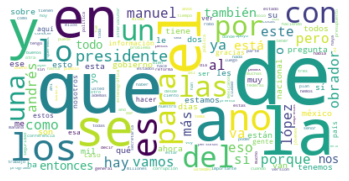

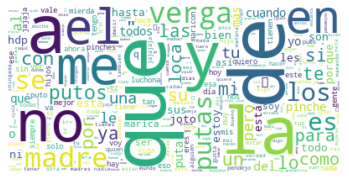

In [ ]:
from wordcloud import WordCloud
tweets_sorted = ngram_data.sortFreqDict(ngram_data.freq_dist)
amlo_sorted = amlo.sortFreqDict(amlo.freq_dist)
dict_amlo_cloud = dict()
dict_tweet_cloud = dict()
for key in amlo_sorted:
  dict_amlo_cloud[key] = amlo.freq_dist[key]

for key in tweets_sorted:
  dict_tweet_cloud[key] = ngram_data.freq_dist[key]

makeImage(dict_amlo_cloud)
print()
makeImage(dict_tweet_cloud)